# Домашнее задание 
# Математика — Домашнее задание 15

# А.&#8201;Д. Егоров

In [1]:
import numpy as np 
from scipy import optimize as opt 
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from typing import Tuple
from collections import Counter

# Подгрузим полезные функции
from utils import *

# Сделаем автоподгрузку всех изменений при перепрогонке ячейки
%load_ext autoreload
%autoreload 2

# plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-light.mplstyle')
plt.style.use("seaborn")

%matplotlib inline
# sns.set_palette(palette="Reds")


## Задание $№\,1$

### Условие
Сгенерируйте датасет со случайными нормально распределенными величинами
$$
    x_1 \sim N\left( \mu_1, \sigma_1^2 \right), 
    \quad 
    x_2 \sim N\left( \mu_2, \sigma_2^2 \right),
    \quad
    x_3 \sim N\left( \mu_3, \sigma_3^2 \right),
$$
$$
    corr(x_1, x_2) = 0.0, 
    \quad
    corr(x_1, x_3) = 0.0, 
    \quad
    corr(x_2, x_3) = 0.8, 
$$
размер выборки $N = 1000$.

Сгенерируйте зависимую переменную $y$ по формуле
$$
    y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \beta_3 x_3 + \varepsilon,
$$
где $\varepsilon \sim N\left(0, \sigma_\varepsilon^2\right), \ \beta_i \ne 0, \ i = \overline{0, 3}.$

Требуется: 

Провести процедуру симуляции выборки для данной задачи на 10 тыс. итерациях.
Итеративно сохранив нужные результаты модели:
1. Проверить утверждение, что "Коэффициет модели $\beta_1$ примерно в $95\%$ итераций попадает в доверительные итревалы коэффициента $\widehat\beta_1$ при уровне значимости $\alpha=0.05$."
2. Найти долю итераций, к которых коэффициенты модели $\beta_2, \ , \beta_3$ попадают в доверительные интервалы для $\widehat\beta_2, \ \widehat\beta_3$.

### Решение

#### Задаем параметры распределений

In [2]:
# Определим параметры выборки для задачи пропущенной переменной
# Создадим удобный словарь, чтобы передавать его в функцию
dist_params = dict(

    # Зададим параметры распределения факторов
    x1_mean = 10.0,
    x1_std = 10.0,
    x2_mean = 20.0,
    x2_std = 12.0,
    x3_mean = 7.0,
    x3_std = 20.0,
    corr_12 = 0.0,
    corr_13 = 0.0,
    corr_23 = 0.8,
    
    # Зададим параметры распределения ошибки
    e_mean = 0.0,
    e_std = 8.0,

    # Укажем размер выборки
    N = 1000,

    # Зададим действительные параметры модели
    beta0 = 33.0,
    beta1 = 7.0,
    beta2 = -5.0,
    beta3 = 44.0,
)

RANDOM_SEED = 42

#### Прогон 10 тыс. итераций

In [3]:
res = {
    "beta_1_in_conf_int": [],
    "beta_2_in_conf_int": [],
    "beta_3_in_conf_int": [],
}

def cond_beta_in_conf_int(beta, conf_int) -> bool:
    return (conf_int[0] <= beta) & (beta <= conf_int[1])

for i in range(0, 10_000):

    dt_var = gen_data(
        y_type="multivariate",
        params=dist_params,
        seed=RANDOM_SEED + i,
    )
    _, model_vars = train_model(
        dt_var,
        target="y",
        feature_names=["x1", "x2", "x3"],
        show_results=False,
        return_norm_tests=False,
    )

    for j in (1, 2, 3):
        res[f"beta_{j}_in_conf_int"].append(
            cond_beta_in_conf_int(
                beta=dist_params[f"beta{j}"],
                conf_int=model_vars.conf_int(alpha=0.05).iloc[j],
            )
        )

In [4]:
cnt_1 = Counter(res["beta_1_in_conf_int"])
cnt_2 = Counter(res["beta_2_in_conf_int"])
cnt_3 = Counter(res["beta_3_in_conf_int"])

print(
    f"""For beta_1:
    \t In conf int: {cnt_1[True]},
    \t Out of conf int: {cnt_1[False]}.\n"""
)

print(
    f"""For beta_2:
    \t In conf int: {cnt_2[True]},
    \t Out of conf int: {cnt_2[False]}.\n"""
)

print(
    f"""For beta_3:
    \t In conf int: {cnt_3[True]},
    \t Out of conf int: {cnt_3[False]}.\n"""
)

For beta_1:
    	 In conf int: 9523,
    	 Out of conf int: 477.

For beta_2:
    	 In conf int: 9475,
    	 Out of conf int: 525.

For beta_3:
    	 In conf int: 9479,
    	 Out of conf int: 521.



#### Интерпретация результатов

#### 1.
$$
    \Big\{ \text{Доля $\beta_1$, попавших в доверительный интервал ($\alpha = 0.05$)} \Big\}
    = \dfrac{9523}{10000} = 0.9523,
$$
что примерно эквивалентно $95\%$. Следовательно, утверждение верное.


#### 2.
$$
    \Big\{ \text{Доля $\beta_2$, попавших в доверительный интервал ($\alpha = 0.05$)} \Big\}
    = \dfrac{9475}{10000} = 0.9475.
$$

$$
    \Big\{ \text{Доля $\beta_3$, попавших в доверительный интервал ($\alpha = 0.05$)} \Big\}
    = \dfrac{9479}{10000} = 0.9479.
$$

## Задание $№\,2$

Загрузите датасет с информацией о сердечных болезнях и их индикаторах - Heart Disease Health Indicators Dataset. Oн
содержит данные по результатам опроса, проведенного в 1985 году, в нем описана выборка респондентов:
- Приведена разметка наличия проблем с сердцем: HeartDiseaseorAttack
- Приведена 21 характеристика респондента о его соц-дем положении и здоровье

Датасет сам по себе уже довольно чистый, поэтому позволяет работать с данными в их сыром виде. Он содержит 253 680 наблюдений, среди которых у 23 893 респондентов присутствовало сердечное заболевание. То есть присутствует несильный, но некий имбаланс классов. Допустим, вы заинтересованы в подготовке модели, которая могла бы помочь врачам идентифицировать склонных к сердечным заболеваниям пациентов. Подготовить такую модель вы решили на предоставленном датасете.

В прикрепленных практических материалах для вас уже подготовлен скрипт, позволяющий оценить модель на этих данных.
Но в демонстрации используется несколько переменных, вам же потребуется весь датасет.

Требуется: 
1. Используя материалы для лекции №4, обучите модель логистической регрессии на данных о сердечных заболеваниях на
всех предоставленных в датасете факторах. Можно использовать настройку 
```class weight='balanced'```. Подготовьте
Classification report, Confusion matrix, график распределения плотности предсказанных скоров модели по классам 0 и 1.
2. Дайте развернутые комментарии по полученным результатам: о чем вам говорят значение метрик Precision и Recall? Как
можно трактовать значения метрик F1-macro, ROC-AUC?
3. Если бы за 1 месяц к вам на осмотр пришло 100 человек и вы ставили диагноз «склонность к сердечным болезням» только
по модели, то в среднем скольким из них вы бы поставили диагноз корректно, ошибочно, скольких потенциальных
больных упустили? Как вы считаете, насколько полученная вами модель хороша для применения на практике для
определения склонных к заболеваниям пациентов?

In [5]:
df_HD = pd.read_csv("./heart_disease_health_indicators_BRFSS2015.csv")
df_HD.shape

(253680, 22)

In [6]:
df_HD.head(5)

,HeartDiseaseorAttack,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,Diabetes,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


#### Пункт 1


 ================================================== TRAIN RESULTS ================================================== 

ROC AUC score: 0.848

              precision    recall  f1-score   support

         0.0       0.97      0.75      0.85    229787
         1.0       0.25      0.80      0.38     23893

    accuracy                           0.75    253680
   macro avg       0.61      0.77      0.61    253680
weighted avg       0.90      0.75      0.80    253680



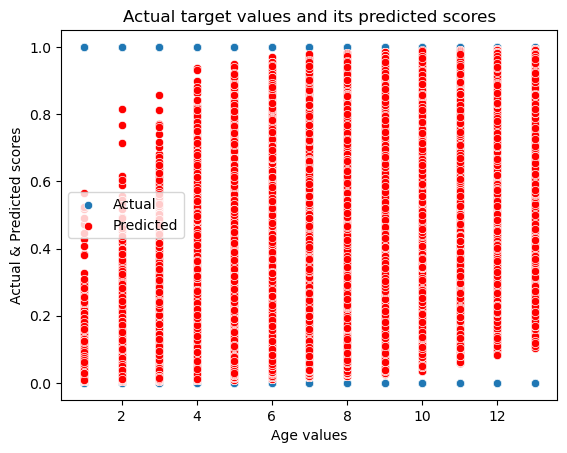

/home/san/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


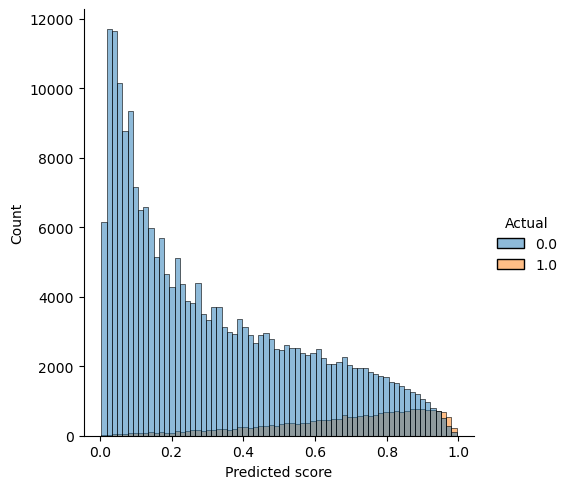

Predicted,0.000000,1.000000
Actual,,
0.000000,171843,57944
1.000000,4893,19000


In [7]:
# Обучим Logit модель на первых 5 колонках + Age
dt_logit, model_logit = train_binary(
    dataset=df_HD, 
    target='HeartDiseaseorAttack',
    feature_names=df_HD.drop(columns=["HeartDiseaseorAttack"]).columns.to_list(),
    plot_feature='Age',
    model_type='logit', 
    pkg='sklearn',
    class_weight='balanced',
)

#### Пункт 2

Отталкиваясь от определений Precision и Recall,

> Precision - доля корректных предсказаний от всех предсказаний отнесенных к конкретному классу

> Recall - доля корректных предсказаний от всех реальных значений пренадлежащих конкретному классу

Можно сказать, что с большой долей вероятности, если модель предсказала, что сердечных заболеваний нет (класс 0.0), то можно ей верить. Но не стоит помнить, что это всего лишь статистика, а не точная диагностика. Диагноз должен ставить квалифицинованный специалист.

Для пациентов, для которых модель выдает положительный результат (класс 1.0), лучшим вариантом будет пройти обследование. 
Хоть модель часто и ошибается при отнесении предсказания к классу 1.0, она покрывает 80% всех пациентов, у кого действительно присутствует заболевание.  

F1-macro составляет 0.61.  

В сравнении с моделью из ноутбука, прикрепленного к лекции, где F1-macro = 0.56, F1-macro вырос, что увеличило валидность использования данной модели.

ROC AUC score: 0.848

ROC AUC показывает, что у нашей модели достаточно хорошее качество ранжирования, что так же указывает на применимость построенной модели.

#### Пункт 3

Из confusion matrix получим доли 

- корректно поставленных диагнозов: 
$$
\dfrac{TP + TN}{N} = \dfrac{19000 + 171843}{253680} = 0.7522981709239988 \approx 0.75,
$$

- ошибочно поставленных диагнозов: 
$$
\dfrac{FP + FN}{N} = \dfrac{57944 + 4893}{253680} = 0.24770182907600127 \approx 0.25,
$$

- шибочно поставленных диагнозов, когда в действительности диагноз положителен:
$$
\dfrac{FN}{N} = \dfrac{4893}{253680} = 0.019288079470198675 \approx 0.02.
$$

То есть из 100 человек для 75 диагноз поставили верно, для 25 ошибочно, для 2 человек отрицательный диагноз был поставлен ошибочно (в действительности болезнь присутствует).

Я считаю, что это хороший результат для модели и она может быть применена на практике, но только как средство дополнительного анализа: исключительно по модели сказать болен человек или нет нельзя.